In [1]:
# 1 Initialization
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.colors as c
from pylatex import Document, Section, Subsection, Tabular, Math, TikZ, Axis, \
    Plot, Figure, Matrix, Alignat
from pylatex.utils import italic
import os
import mpmath
import os
import numpy as np
from astropy.io import fits
from datetime import datetime

In [2]:
# 2 Important Parameters
observingLatitudeDegrees = 30 # Observing latitude - Default : 35
viewLength = 6e17 # Length of the display box - Default : 6e17
resolution = 100 # Number of pixels of one side of the display - Default : 200
distance_steps = 3000 # Number of distance steps in the optical depth center array - Default : 3000
angle_steps = 1800 # Number of angle steps in the optical depth center array - Default : 1800
absorptionSteps_center = 10 # Number of steps between two adjacent elements of the spherical optical depth array - Default : 10
absorptionSteps = 100 # Number of steps between two adjacent elements in the cubical optical depth array - Default : 5

In [3]:
# 3 Nebula Shape Parameters
# Basic shape properties of the nebula
Rin = 1e16 # Inner cavity radius - Default : 1e16
power = 1.9 # Density inverse relation to radius - Default : 2
density_enhancement = 7 # Density enhancement factor - Default : 5

In [4]:
# 4 Nebula Content Parameters
# Mass properties of the nebula
# Luminosity_Solar_Luminosity = 1 # Luminosity of the central star in Solar Luminosity
# Luminosity = Luminosity_Solar_Luminosity*3.83e26 # Luminosity of the central star in Watts
Mdot_Solar_Mass = 1e-5 # Mass loss rate of all molecules in solar masses - Default : 1e-5
Mdot = Mdot_Solar_Mass*2e33/(365*24*60*60) # Mass loss rate of all molecules in g/seconds
particle_radius = 1e-5 # cm - Default : 1e-5 / smaller
wavelength = 5e-5 # cm - Default : 5e-5
effective_crosssection = (np.pi*particle_radius**2)*2*np.pi*(particle_radius/(wavelength)) # Per grain per cm^2
dust_to_gas = 1/200 # Dust to gas ratio - Default : 1/200
grain_mass = 1.3e-14 # Mass of the individual grain in grams - Default : 1.3e-14
asymmetry_constant = 0.2 # The scattering asymmetry constant - Default : 0.2

In [5]:
# 5 Pre-compute Important Numbers
observingLatitude = np.pi*(observingLatitudeDegrees/180) # The latitude the observer is currently at in radians
sin = np.sin(observingLatitude) # precompute the trigs of the observer
cos = np.cos(observingLatitude)
viewSize = viewLength/2 # Half the size of the picture

In [6]:
# 6 Logistic functions
def norm(x):
    return np.sqrt(x[0]**2+x[1]**2+x[2]**2)
  # norm(): returns the norm of a given vector x (the vector is in the form of np.array([x,y,z]))

def vector_angle(v1,v2):
    norm1 = norm(v1)
    norm2 = norm(v2)
    if norm1==0 or norm2==0:
        return 0
    else:
        factor = np.dot(v1,v2)/(norm1*norm2)
        if factor > 1:
            return 0
        elif factor < -1:
            return np.pi
        else:
            return np.arccos(factor)
    # vector_angle(): returns the angle between two cartesian vectors

def spherical_to_cartesian(r):
    sin_cur=np.sin(r[1])
    return np.array([r[0]*sin_cur*np.cos(r[2]),r[0]*sin_cur*np.sin(r[2]),r[0]*np.cos(r[1])])
  # spherical_to_cartesian(): returns the cartesian representation of the given spherical vector r
  # the cartesian vector x is defined in the refernce frame of nebula, not the observer

def cartesian_to_spherical(x):
    norm = np.sqrt(x[0]**2+x[1]**2+x[2]**2) # pre compute the norm of the vector
    if norm==0:
        return np.array([0,0,0])
    elif x[0]==0:
        return np.array([norm,np.arccos(x[2]/norm),np.pi/2])
    else:
        return np.array([norm,np.arccos(x[2]/norm),np.arctan(x[1]/x[0])])
    # cartesian_to_spherical(): returns the spherical representation of the cartesian vector x
    # the cartesian vector x is defined in the reference frame of nebula, not the observer

In [7]:
# 7 Scattering Phase Function
def phase_function(angle): # Henyey-Greenstein
    return 1/(4*np.pi)*(1 - asymmetry_constant**2)/((1 + asymmetry_constant**2 - 2*asymmetry_constant*np.cos(angle))**(3/2))

In [8]:
# 8 Detailed Shape of the Nebula
def lobe(x,y): #both must be positive absolute values
    if x>=1.7e17 and x*y<=2.589e16*1.8e17:
        if x*y<=2.085e16*1.8e17:
            return 1
        return 2
    elif (y+1.01e17)**2+(x-1e17)**2<=2.2e34:
        if (y+1.06e17)**2+(x-1e17)**2<=2.2e34:
            return 1 # The normal lobe region
        return 2 # The enhanced region
    else:
        return 0

def density(latitude,distance):
    if distance < Rin/2:
        return 0
    sin_lat = np.abs(np.sin(latitude))
    lat = np.abs(latitude/np.pi*2)
    y_cur = distance*np.sqrt(1-sin_lat**2)
    x_cur = distance*sin_lat
    if lobe(x_cur,y_cur)==1:
        velocity = 2e7
        dr_cur = 1.05e16 # sharpness of the cutoff/cutoff length, unit in cm
        if lat>=85/90:
            R_cur = 1e17#1.87e+17 # cutoff radius, unit in cm
        else:
            R_cur = 1.6e17#1.87e+17 # cutoff radius, unit in cm
    elif lobe(x_cur,y_cur)==2:
        velocity = 2e7/density_enhancement
        dr_cur = 1.05e16 # sharpness of the cutoff/cutoff length, unit in cm
        R_cur = 1.87e17 # cutoff radius, unit in cm
    elif distance<=7e16+5e14: # disk(x_cur,y_cur)==1: # Disk
        velocity = 1e6
        dr_cur = 5e14
        R_cur = 8e16
    else:
        velocity = 5e7+5e8*sin_lat**3
        dr_cur = 5e14+2e16*lat**3
        R_cur = 2e17#7e16+1.3e17*lat**3
        
    cutoff_outer = 0.5*(1 - np.tanh((distance-R_cur)/dr_cur))
    cutoff_inner = 0.5*(1 - np.tanh((Rin-distance)/(Rin/2)))
    
    return (dust_to_gas*Mdot/grain_mass)*(cutoff_outer*cutoff_inner)/(4*np.pi*(distance**power)*velocity)
def density_cartesian(x):
    spherical = cartesian_to_spherical(x) # x in spherical coordinates
    return density(np.pi/2-spherical[1],spherical[0])

In [9]:
# 9 Density Display Function
@np.vectorize
def density_map(x,y):
    return density_cartesian(np.array([0,y,-x]))**(1/float(5))
# Density display, density scales by the power of 1/5

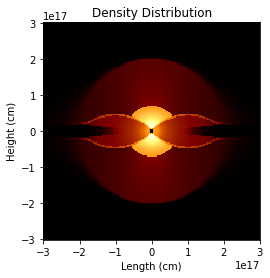

In [10]:
# 10 Density Display
side = np.linspace(-viewSize,viewSize,2*resolution+1)
x,y = np.meshgrid(side,side)
Value = density_map(x,y)
plt.xlabel("Length (cm)")
plt.ylabel("Height (cm)")
plt.title("Density Distribution")
plt.pcolormesh(x,y,Value,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')

In [11]:
density(np.pi/4,7e16)

1.9158164619959745e-07

In [83]:
# 11 Array Coordinate - Skyplane Coordinate Translations
def coord_to_index(x,y): 
    # coord_to_index(): Returns the array index i given the skyplane coordinates x,y in cm 
    return int(int(((x/viewSize)+1)*(resolution/2))+int((y/viewSize)*(resolution/2))*(resolution+1))
def index_to_x(i):
    # index_to_x(): Returns the skyplane coordinate x given the array index i
    return (int(i%(resolution+1))/(resolution/2)-1)*viewSize
def index_to_y(i):
    # index_to_y(): Returns the skyplane coordinate y given the array index i
    return (int(i/(resolution+1))/(resolution/2))*viewSize

In [84]:
# 12 Define Spherical Optical Depth Integration Function
def optical_depth_center_progression(latitude,distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density(latitude,distance+i*(viewSize/(distance_steps*absorptionSteps_center)))
        sum += add # add the non constant density
        i += 1/absorptionSteps_center
    sum = effective_crosssection*sum*(2*viewSize/(distance_steps*absorptionSteps_center)) # now multiply the constants of the integrand
    return sum # return the result

In [85]:
# 13 Spherical Optical Depth Array
# Define the spherical optical depth array
# i from 0 to distance_steps, represents distance from 0 to 2*viewSize
# j from 0 to pi/2, represents the latitude
i, j = distance_steps+1, angle_steps+1
optical_depth_center_array = [[0 for x in range(i)] for y in range(j)]

In [86]:
# 14 Computing The Spherical Optical Depth Array
for i in range(0,angle_steps):
    for j in range(0,distance_steps):
        # For each angle, accumulatively compute the optical depth
        add = optical_depth_center_progression(i*np.pi/(2*angle_steps),j*(2*viewSize/distance_steps))
        optical_depth_center_array[i][j] = optical_depth_center_array[i][j-1] + add

In [87]:
# 15 Define Cubical Optical Depth Integration Function
n = 2*viewSize/resolution
def optical_depth_progression(x1,x2):
    # optical_depth_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density_cartesian(x1+i*(x2-x1))
        sum += add # add the non constant density
        i += 1/absorptionSteps
    sum = effective_crosssection*sum*n/absorptionSteps # now multiply the constants of the integrand
    return sum # return the result

In [88]:
# 16 Cubical Optical Depth Array
# Define the cubical optical depth array
# j is the depth, "0" is the closest to the viewplane, "resolution" isthe deepest, resolution+1 steps in total
# i is the coordinate, is the x*(resolution+1)+y, minimum 0 (x minimum, y=0), maximum (resolution+1)*(resolution)-1 (top right corner)
# here x and y are pixel coordinates, from 0 to resolution
i, j = resolution+1, (resolution+1)*(int(resolution/2)+1)
optical_depth_array = [[0 for x in range(i)] for y in range(j)]

In [89]:
# 17 Computing The Cubical Optical Depth Array
for i in range(0,(resolution+1)*(int(resolution/2)+1)-1):
    for j in range(0,resolution):
        # For each coordinate, accumulate the optical depth along the line of sight
        x = index_to_x(i)
        y = index_to_y(i)
        add = optical_depth_progression(np.array([x*sin+(((resolution/2)-j)/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-j)/(resolution/2)*viewSize)*sin]),np.array([x*sin+(((resolution/2)-(j-1))/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-(j-1))/(resolution/2)*viewSize)*sin]))
        optical_depth_array[i][j] = optical_depth_array[i][j-1] + add

In [90]:
# 18 Saving Data Arrays
import csv
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%Hh%Mm%Ss")
month_string = now.strftime("%m_%Y")
if os.path.exists("desktop/Research/"+month_string)==False:
    os.makedirs("desktop/Research/"+month_string)
np.savetxt("desktop/Research/"+month_string+"/"+dt_string+"_odc.csv", optical_depth_center_array, delimiter=",")
np.savetxt("desktop/Research/"+month_string+"/"+dt_string+"_od.csv", optical_depth_array, delimiter=",")

In [91]:
# 19 Reading Data Arrays
optical_depth_center_array = np.loadtxt("desktop/Research/"+month_string+"/"+dt_string+"_odc.csv",skiprows=0,delimiter = ',')
optical_depth_array = np.loadtxt("desktop/Research/"+month_string+"/"+dt_string+"_od.csv",skiprows=0,delimiter = ',')

In [92]:
asymmetry_constant = 0.5 # This can change with each recompute, without altering the array, mainly changing fromt/back ratio
scale_factor = 100 # The post-compute multiplier applied to the density/optical depth array
@np.vectorize
def intensity(x,y):
    if x==0 and y==0:
        return 0
    i = coord_to_index(x,y)
    sum = 0.0
    for j in range(0,resolution):
        cur = np.array([x*sin+(((resolution/2)-j)/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-j)/(resolution/2)*viewSize)*sin]) # current point (precise value stored in array)
        spherical = cartesian_to_spherical(cur) # spherical of current point, to find the optical depth center
        o_d_center = scale_factor*optical_depth_center_array[np.abs(int((angle_steps/90)*(90-(180*spherical[1]/np.pi))))][int(spherical[0]/(2*viewSize)*distance_steps)]
        o_d = scale_factor*optical_depth_array[i][j]
        add = ((1/spherical[0])**2)*mpmath.exp(-o_d)*mpmath.exp(-o_d_center)*scale_factor*effective_crosssection*density(np.pi/2-spherical[1],spherical[0])*phase_function(vector_angle(np.array([cos,0,sin]),cur))
        sum += add
    return sum

In [93]:
# 21 Computing The Top Half Intensity Array
side = np.linspace(-viewSize,viewSize,resolution+1)
sideY = np.linspace(0,viewSize,int(resolution/2)+1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
Value = intensity(x,y) # compute half of the intensity map

In [94]:
# 22 Generating Full Image
@np.vectorize
def findValue(x,y):
    cur_x = int(x*resolution/(2*viewSize)) + int(resolution/2)
    cur_y = int(y*resolution/(2*viewSize))
    if y > 0:
        return float(Value[cur_y-1][cur_x])
    elif y==0:
        if x==0:
            return 0
        return float(Value[0][cur_x])
    else:
        return float(Value[-cur_y-1][cur_x])
X,Y = np.meshgrid(side,side)
np.seterr(divide='ignore')
fullValues = findValue(X,Y)

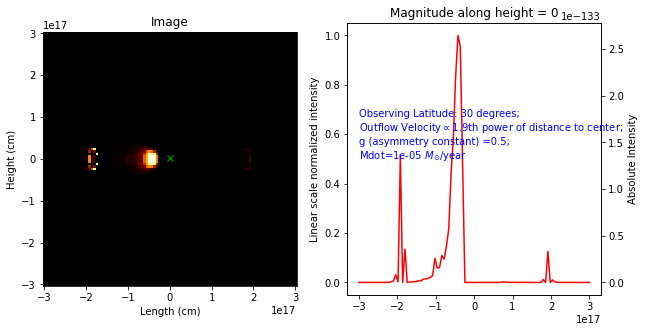

In [95]:
# 23 Plots
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121, aspect=1)

plt.xlabel("Length (cm)")
plt.ylabel("Height (cm)")
plt.title("Image")
ax.pcolormesh(X,Y,fullValues,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')
# plt.annotate('*', xy=(-0.080,-0.205), color = 'green', size = 20, label = 'star')
ax.scatter(np.array([0]),np.array([3.3e15]),color = 'green', marker = 'x')
# fig, ax = plt.subplots()
# CS = ax.contour(X,Y,logFullValues)
# plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-viewSize,viewSize,resolution+1)
y_array = Value[0]
normalizedYArray = y_array/np.max(np.nan_to_num(np.array(y_array, dtype=float)))
ax2.plot(x_array,normalizedYArray, color = 'red')
x_pos = (1+np.min(normalizedYArray))/2
ax2.set_ylabel("Linear scale normalized intensity")
plt.title("Magnitude along height = 0")

plt.annotate("Observing Latitude: "+str(observingLatitudeDegrees)+" degrees;\nOutflow Velocity"+r'$\propto$'+str(power)+"th power of distance to center;\n"+"g (asymmetry constant) ="+str(asymmetry_constant)+";\nMdot="+str(Mdot_Solar_Mass)+" "+'$ M_{\odot}$'+"/year", xy=(-viewSize,x_pos), color = 'blue')

ax3=ax2.twinx()
ax3.plot(x_array,np.nan_to_num(np.array(y_array, dtype=float)), color = 'blue', alpha = 0)
ax3.set_ylabel("Absolute Intensity")

plt.show()

In [96]:
# 24 Saving Fits Files
modifiedValues = fullValues*1e61
hdul = fits.PrimaryHDU(data=modifiedValues)
now = datetime.now()
t_string = now.strftime("%m_%d_%Y_%Hh%Mm%Ss")
m_string = now.strftime("%m_%Y")
if os.path.exists("desktop/Research/"+m_string)==False:
    os.makedirs("desktop/Research/"+m_string)
string = "desktop/Research/"+m_string+"/"+t_string+"_power_"+str(power)+"_multiplier_"+str(scale_factor)+"_1.fits"
hdul.writeto(string)